### VED index clustering - python-only pipeline



In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [2]:
import scipy
import netCDF4 as nc
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import cmocean as cm
import pipvis as vp
from importlib import reload

import sys
sys.path.append('./extraction_scripts')
import map_fxn as mf
reload(vp)


<module 'pipvis' from '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pipvis.py'>

## masking edges

In [3]:
bath = '/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc'
grid = mf.import_bathy(bath)
fmask = (grid.fmask[0,0,:,:]) 

stn_x, stn_y = mf.make_stns(10)
d_stn_x, d_stn_y = mf.filter_stn_in_domain(stn_x,stn_y,fmask)

d_stn_xar = np.array(d_stn_x)
d_stn_yar = np.array(d_stn_y)

edge = np.where((d_stn_xar<=10) | (d_stn_yar>=888))
np.squeeze(edge)
np.shape(edge)
edgear = np.array(edge)
edgear = edgear[0]

d_stn_xar =np.delete(d_stn_xar,edge)
d_stn_yar = np.delete(d_stn_yar,edge)

print(np.size(d_stn_xar))


571



#### agglomerate signals extracted and save as .pkl, for year in 2013-2016

In [4]:
# do this for years 2013  to 2016
years = ['2013','2014','2015','2016']

for year in years:
    if year == '2016':
        noday = 366
    if year != '2016':
        noday = 365
        
    print(year)
    basedir = '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/NC_HINDCAST/'


    varfolder = 'VED_TS'
    tname = './pkls/ved_datamat_'+year+'.pkl'
    signalmat = np.zeros([np.size(d_stn_xar),noday])
    count = 0 
    for i in range(0,580):
        
        if i not in edgear:

            pattern  = f'stn_{i}avg_ved_sp10.nc' #stn_0avg_ved_sp10.nc
            tdat = nc.Dataset(basedir+year +'/'+ varfolder +'/'+pattern)
            signalmat[count,:] = tdat['daily_ved'][:]
            count = count+1

    pickle.dump(signalmat, open(tname, 'wb'))


2013
2014
2015
2016


## open the resulting signalmats, cluster from 2-N (N=100) clusters, save linkage matrix and cluster matrices, visualise dendrograms

In [5]:
for year in years:
    print(year)
    signalmat = pickle.load(open('./pkls/ved_datamat_'+year+'.pkl', 'rb'))

    Z = linkage(signalmat, 'ward')
    pickle.dump(Z, open('./pkls/ved_linkmat_'+year+'.pkl', 'wb'))
    
    clustermat = np.zeros([100,np.size(d_stn_xar)])                           
    for k in range(0,100): 
        clustermat[k,:] = fcluster(Z, k+1, criterion='maxclust')
    pickle.dump(clustermat, open('./pkls/ved_clustmat_'+year+'.pkl', 'wb'))

2013
2014
2015
2016


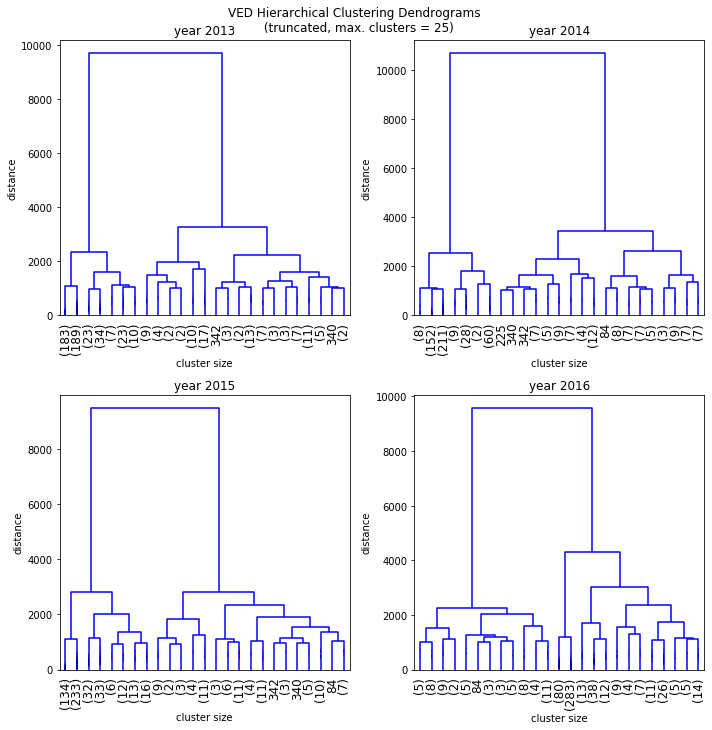

In [18]:
fact = 1
ms = 4
markersize = 10
legfontsize = 8

fig = plt.figure(figsize=(10*fact, 10*fact))

#####halo
ax1 = plt.subplot2grid((2,2),(0,0))
Z = pickle.load(open('./pkls/halo_linkmat_2013.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2013'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(0,1))
Z = pickle.load(open('./pkls/halo_linkmat_2014.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2014'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(1,0))
Z = pickle.load(open('./pkls/halo_linkmat_2015.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2015'); plt.xlabel('cluster size'); plt.ylabel('distance')

ax1 = plt.subplot2grid((2,2),(1,1))
Z = pickle.load(open('./pkls/halo_linkmat_2016.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2016'); plt.xlabel('cluster size'); plt.ylabel('distance')

plt.suptitle('VED Hierarchical Clustering Dendrograms \n (truncated, max. clusters = 25)', y = 1.01)
plt.tight_layout()
plt.show()

var = 'VED'
fig.savefig(f'./paper_figs/{var}_dendrograms.pdf', bbox_inches='tight')


#### 'objective' measures of clustering are sometimes hard to defend

##### one way to circumvent this obvious problem is to look manually at the visual clusters provided


## 2013

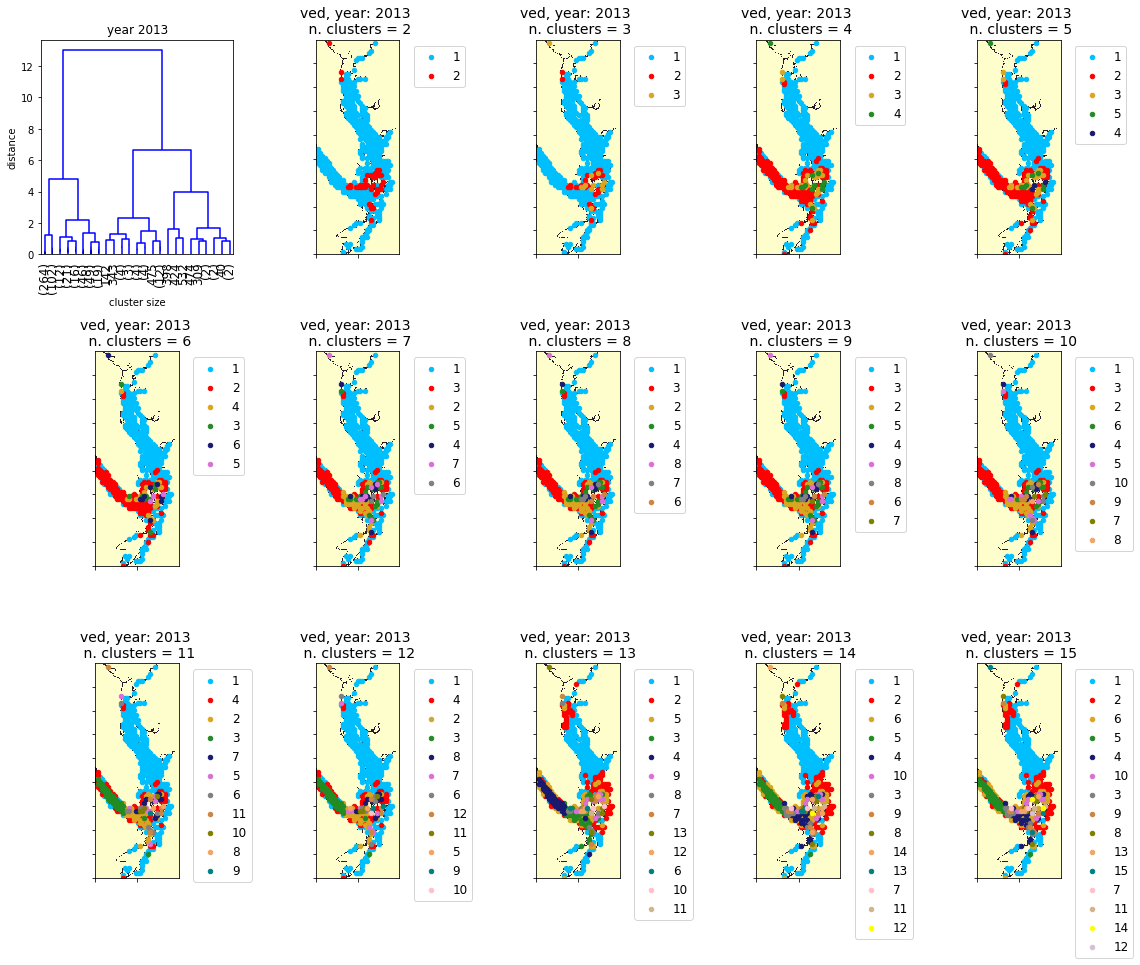

In [8]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/ved_linkmat_2013.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2013'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2013','ved',2)
vp.clusters(axs[0,2],'2013','ved',3)
vp.clusters(axs[0,3],'2013','ved',4)
vp.clusters(axs[0,4],'2013','ved',5)

vp.clusters(axs[1,0],'2013','ved',6)
vp.clusters(axs[1,1],'2013','ved',7)
vp.clusters(axs[1,2],'2013','ved',8)
vp.clusters(axs[1,3],'2013','ved',9)
vp.clusters(axs[1,4],'2013','ved',10)

vp.clusters(axs[2,0],'2013','ved',11)
vp.clusters(axs[2,1],'2013','ved',12)
vp.clusters(axs[2,2],'2013','ved',13)
vp.clusters(axs[2,3],'2013','ved',14)
vp.clusters(axs[2,4],'2013','ved',15)

plt.tight_layout()

var = 'VED'
year = 2013
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')



## 2014

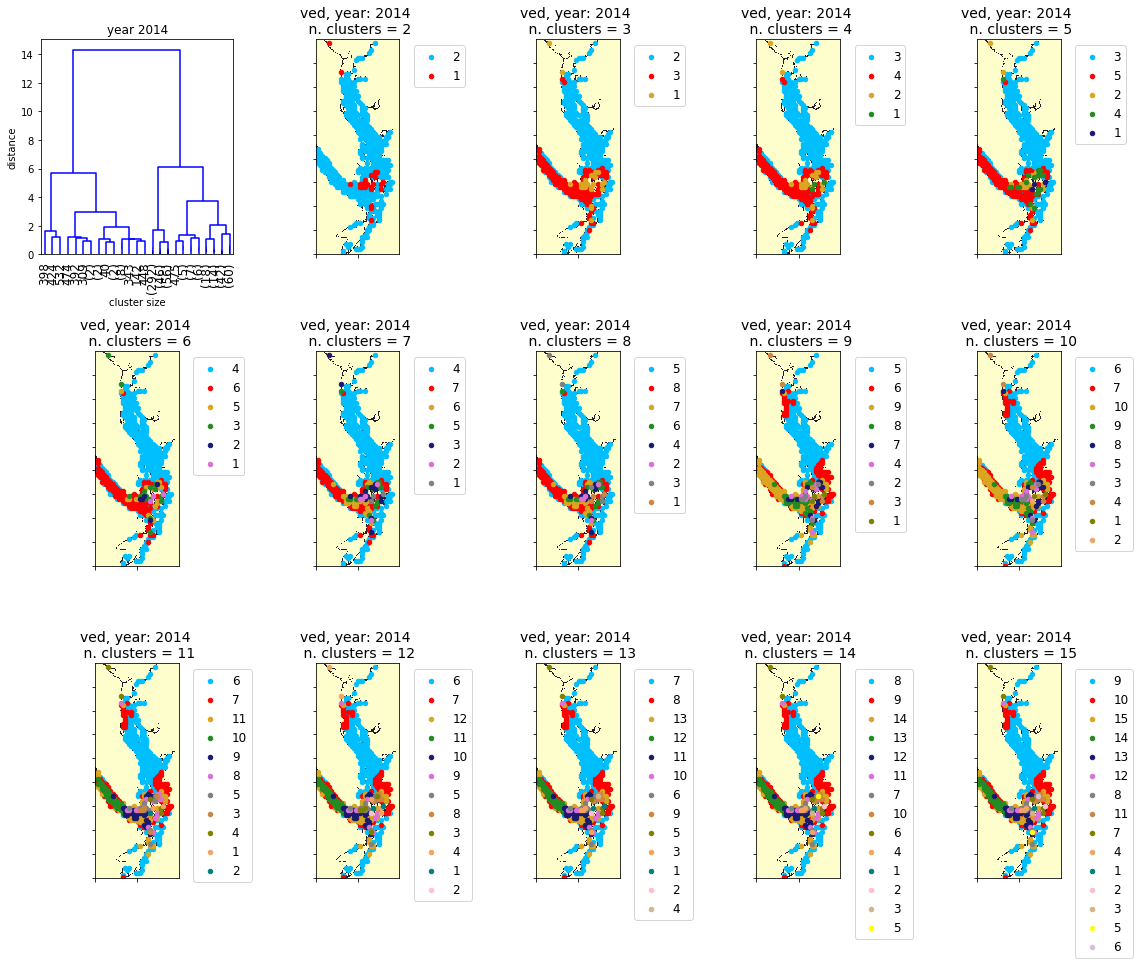

In [9]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/ved_linkmat_2014.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2014'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2014','ved',2)
vp.clusters(axs[0,2],'2014','ved',3)
vp.clusters(axs[0,3],'2014','ved',4)
vp.clusters(axs[0,4],'2014','ved',5)

vp.clusters(axs[1,0],'2014','ved',6)
vp.clusters(axs[1,1],'2014','ved',7)
vp.clusters(axs[1,2],'2014','ved',8)
vp.clusters(axs[1,3],'2014','ved',9)
vp.clusters(axs[1,4],'2014','ved',10)

vp.clusters(axs[2,0],'2014','ved',11)
vp.clusters(axs[2,1],'2014','ved',12)
vp.clusters(axs[2,2],'2014','ved',13)
vp.clusters(axs[2,3],'2014','ved',14)
vp.clusters(axs[2,4],'2014','ved',15)

plt.tight_layout()
year = 2014
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')



## 2015 

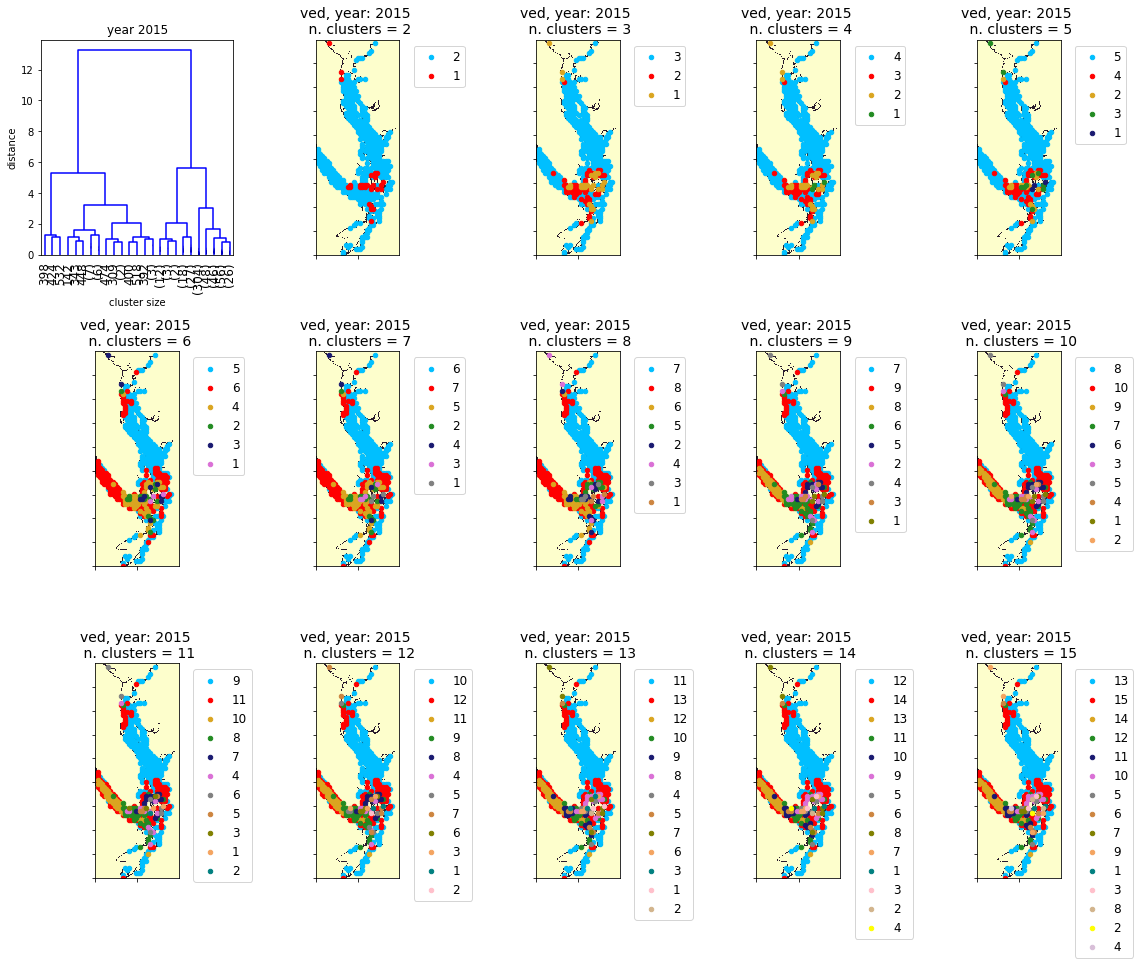

In [10]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/ved_linkmat_2015.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2015'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2015','ved',2)
vp.clusters(axs[0,2],'2015','ved',3)
vp.clusters(axs[0,3],'2015','ved',4)
vp.clusters(axs[0,4],'2015','ved',5)

vp.clusters(axs[1,0],'2015','ved',6)
vp.clusters(axs[1,1],'2015','ved',7)
vp.clusters(axs[1,2],'2015','ved',8)
vp.clusters(axs[1,3],'2015','ved',9)
vp.clusters(axs[1,4],'2015','ved',10)

vp.clusters(axs[2,0],'2015','ved',11)
vp.clusters(axs[2,1],'2015','ved',12)
vp.clusters(axs[2,2],'2015','ved',13)
vp.clusters(axs[2,3],'2015','ved',14)
vp.clusters(axs[2,4],'2015','ved',15)

plt.tight_layout()

year = 2015
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')


## 2016

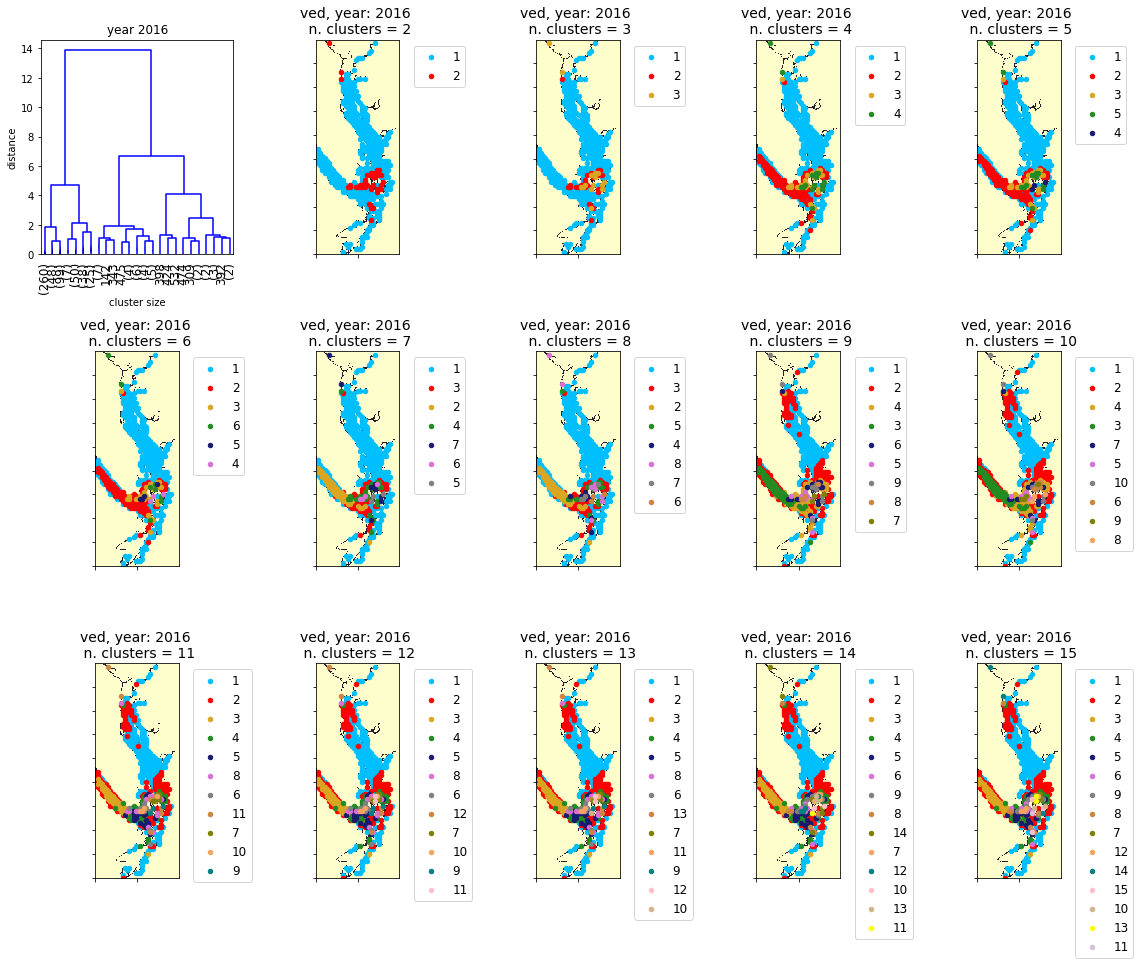

In [11]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/ved_linkmat_2016.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('year 2016'); plt.xlabel('cluster size'); plt.ylabel('distance')


vp.clusters(axs[0,1],'2016','ved',2)
vp.clusters(axs[0,2],'2016','ved',3)
vp.clusters(axs[0,3],'2016','ved',4)
vp.clusters(axs[0,4],'2016','ved',5)

vp.clusters(axs[1,0],'2016','ved',6)
vp.clusters(axs[1,1],'2016','ved',7)
vp.clusters(axs[1,2],'2016','ved',8)
vp.clusters(axs[1,3],'2016','ved',9)
vp.clusters(axs[1,4],'2016','ved',10)

vp.clusters(axs[2,0],'2016','ved',11)
vp.clusters(axs[2,1],'2016','ved',12)
vp.clusters(axs[2,2],'2016','ved',13)
vp.clusters(axs[2,3],'2016','ved',14)
vp.clusters(axs[2,4],'2016','ved',15)

plt.tight_layout()

year = 2016
fig.savefig(f'./paper_figs/{var}_{year}_clustering.png', bbox_inches='tight')


#### 

In [12]:
cl_2013 = pickle.load(open('./pkls/ved_clustmat_2013.pkl', 'rb'))
cl_2014 = pickle.load(open('./pkls/ved_clustmat_2014.pkl', 'rb'))
cl_2015 = pickle.load(open('./pkls/ved_clustmat_2015.pkl', 'rb'))
cl_2016 = pickle.load(open('./pkls/ved_clustmat_2016.pkl', 'rb'))
sig_2013 = pickle.load(open('./pkls/ved_datamat_2013.pkl', 'rb'))
sig_2014 = pickle.load(open('./pkls/ved_datamat_2014.pkl', 'rb'))
sig_2015 = pickle.load(open('./pkls/ved_datamat_2015.pkl', 'rb'))
sig_2016 = pickle.load(open('./pkls/ved_datamat_2016.pkl', 'rb'))


## visualize original clusterings by size and do manual relabeling

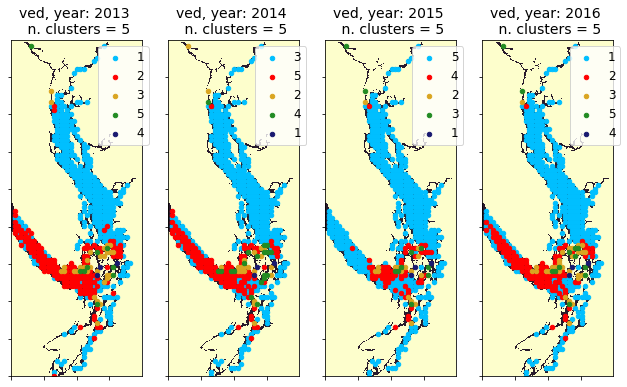

In [13]:
fact = 0.6
fig, axs = plt.subplots(1,4,figsize=(18*fact,15*fact))

vp.clusters(axs[0],'2013','ved',5)
vp.clusters(axs[1],'2014','ved',5)
vp.clusters(axs[2],'2015','ved',5)
vp.clusters(axs[3],'2016','ved',5)

var = 'ved'
year = 2013
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2013_reass = np.zeros_like(cl_this)
cldes_2013_reass[cl_this == 1] = 3
cldes_2013_reass[cl_this == 2] = 5
cldes_2013_reass[cl_this == 3] = 1
cldes_2013_reass[cl_this == 4] = 4
cldes_2013_reass[cl_this == 5] = 2

year = 2014
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2014_reass = np.zeros_like(cl_this)
cldes_2014_reass[cl_this == 1] = 4
cldes_2014_reass[cl_this == 2] = 1
cldes_2014_reass[cl_this == 3] = 3
cldes_2014_reass[cl_this == 4] = 2
cldes_2014_reass[cl_this == 5] = 5

year = 2015
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2015_reass = np.zeros_like(cl_this)
cldes_2015_reass[cl_this == 1] = 4
cldes_2015_reass[cl_this == 2] = 1
cldes_2015_reass[cl_this == 3] = 2
cldes_2015_reass[cl_this == 4] = 5
cldes_2015_reass[cl_this == 5] = 3

year = 2016
tpkl = f'./pkls/{var}_clustmat_{year}.pkl'  
cl = pickle.load(open(tpkl, 'rb'))
no_clusters = 5    
cl_this = cl[no_clusters-1,:]
cldes_2016_reass = np.zeros_like(cl_this)
cldes_2016_reass[cl_this == 1] = 3
cldes_2016_reass[cl_this == 2] = 5
cldes_2016_reass[cl_this == 3] = 1
cldes_2016_reass[cl_this == 4] = 4
cldes_2016_reass[cl_this == 5] = 2





## chceck that reassigning worked

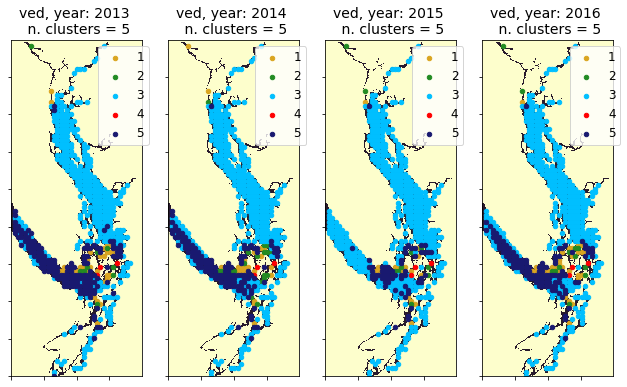

In [14]:
colors = ['white',
          'goldenrod',
          'forestgreen',
          'deepskyblue',
          'red',
          'midnightblue',
          'deepskyblue','gray','peru',
'olive','sandybrown','teal','pink','tan',
'yellow','thistle']
    
reload(vp)
fig, axs = plt.subplots(1,4,figsize=(18*fact,15*fact))

vp.clusters_basic(axs[0],'2013','ved',5,cldes_2013_reass, colors)
vp.clusters_basic(axs[1],'2014','ved',5,cldes_2014_reass, colors)
vp.clusters_basic(axs[2],'2015','ved',5,cldes_2015_reass, colors)
vp.clusters_basic(axs[3],'2016','ved',5,cldes_2016_reass, colors)

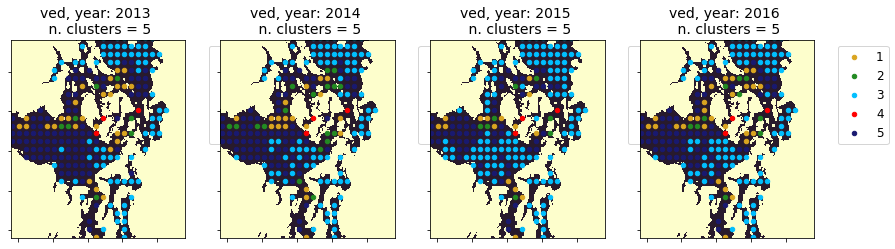

In [23]:
colors = ['white',
          'goldenrod',
          'forestgreen',
          'deepskyblue',
          'red',
          'midnightblue',
          'deepskyblue','gray','peru',
'olive','sandybrown','teal','pink','tan',
'yellow','thistle']
    
reload(vp)
fact = 0.8
fig, axs = plt.subplots(1,4,figsize=(18*fact,10*fact))

vp.clusters_basic(axs[0],'2013','ved',5,cldes_2013_reass, colors)
axs[0].set_xlim([140,390])
axs[0].set_ylim([140,390])
vp.clusters_basic(axs[1],'2014','ved',5,cldes_2014_reass, colors)
axs[1].set_xlim([140,390])
axs[1].set_ylim([140,390])
vp.clusters_basic(axs[2],'2015','ved',5,cldes_2015_reass, colors)
axs[2].set_xlim([140,390])
axs[2].set_ylim([140,390])
vp.clusters_basic(axs[3],'2016','ved',5,cldes_2016_reass, colors)
axs[3].set_xlim([140,390])
axs[3].set_ylim([140,390])


fig.savefig(f'./paper_figs/VED_harocloseup_clustering.png', bbox_inches='tight')


In [24]:
pickle.dump(cldes_2013_reass, open('./pkls/VED_clno_5_2013_reass.pkl', 'wb'))
pickle.dump(cldes_2014_reass, open('./pkls/VED_clno_5_2014_reass.pkl', 'wb'))
pickle.dump(cldes_2015_reass, open('./pkls/VED_clno_5_2015_reass.pkl', 'wb'))
pickle.dump(cldes_2016_reass, open('./pkls/VED_clno_5_2016_reass.pkl', 'wb'))

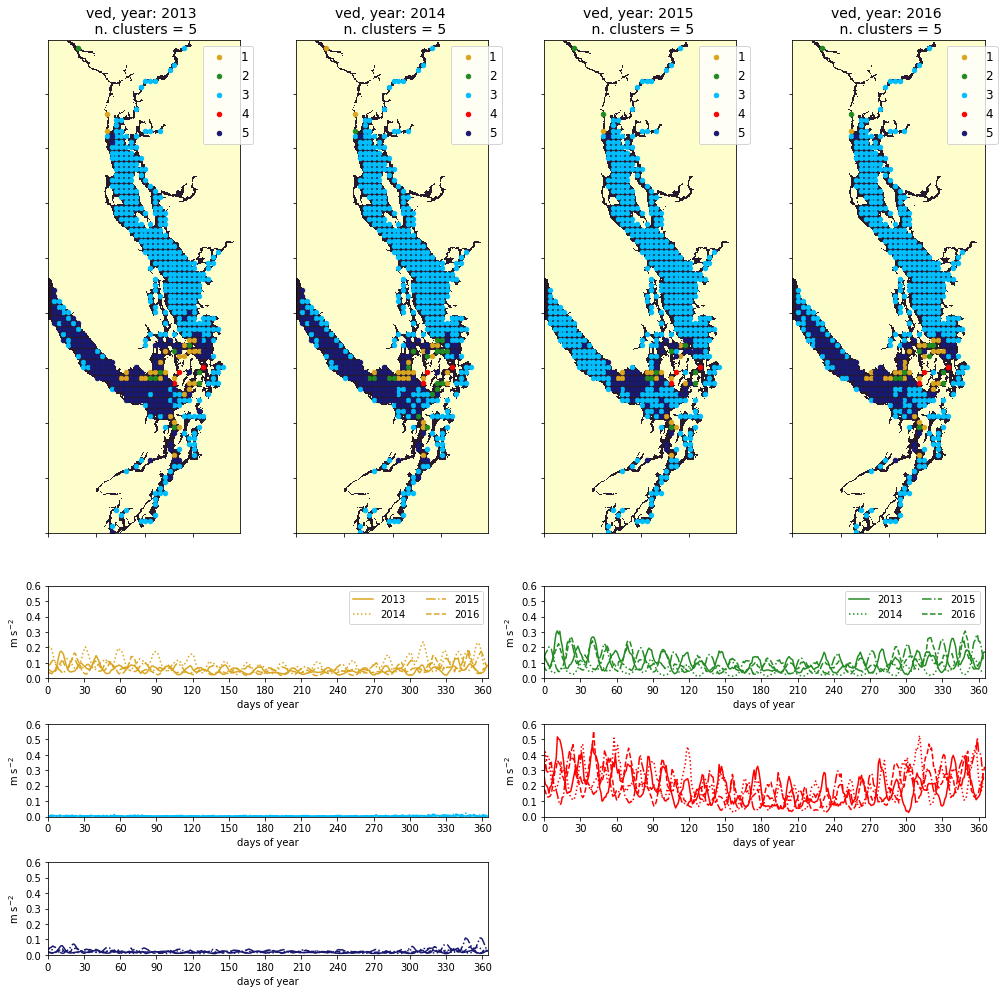

In [29]:
linestyl = ['-',':','-.','--']
sigmats = [sig_2013,sig_2014,sig_2015,sig_2016]
clustmats = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
clustnos = [5,5,5,5]
nodays =  [365,365,365,366]
labs = ['2013','2014','2015','2016']
t_ylim = 0.6
t_ylab = 'm s$^{-2}$'

fact = 2
fig = plt.figure(figsize=(7*fact, 7*fact))

ax1 = plt.subplot2grid((7,4), (0,0), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2013','ved',5,cldes_2013_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,1), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2014','ved',5,cldes_2014_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,2), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2015','ved',5,cldes_2015_reass, colors)
ax1 = plt.subplot2grid((7,4), (0,3), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2016','ved',5,cldes_2016_reass, colors)

ax1 = plt.subplot2grid((7,4), (4,0), colspan=2, rowspan=1)
clustdes = [1,1,1,1]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[1],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim+0.1,0.1));
ax1.legend(loc = 'best', ncol = 2)

ax1 = plt.subplot2grid((7,4), (4,2), colspan=2, rowspan=1) 
clustdes = [2,2,2,2]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[2],\
                linestyle = linestyl[i], label = labs[i])

ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim+0.1,0.1));
ax1.legend(loc = 'best', ncol = 2)

ax1 = plt.subplot2grid((7,4), (5,0), colspan=2, rowspan=1) 
clustdes = [3,3,3,3]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[3],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim+0.1,0.1));

ax1 = plt.subplot2grid((7,4), (5,2), colspan=2, rowspan=1) 
clustdes = [4,4,4,4]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[4],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim+0.1,0.1));

ax1 = plt.subplot2grid((7,4), (6,0), colspan=2, rowspan=1) 
clustdes = [5,5,5,5]
for i in range(0,len(clustdes)):
    tclmat = clustmats[i]; clustno = clustnos[i]
    tmean = vp.cluster_patterns_mean(sigmats[i],tclmat,clustdes[i],nodays[i])
    ax1.plot(np.arange(0,nodays[i],1),np.squeeze(tmean), color = colors[5],\
                linestyle = linestyl[i], label = labs[i])
ax1.set_xlim([0,365]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_yticks(np.arange(0,t_ylim+0.1,0.1));


plt.tight_layout()

var = 'VED'
fig.savefig(f'./paper_figs/{var}_4Y_CLUSTERS_SEP.png', bbox_inches='tight')

/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pipvis.py:115: RuntimeWarning: Mean of empty slice
  mean_signal = np.nanmean(signalmat, axis = 0)


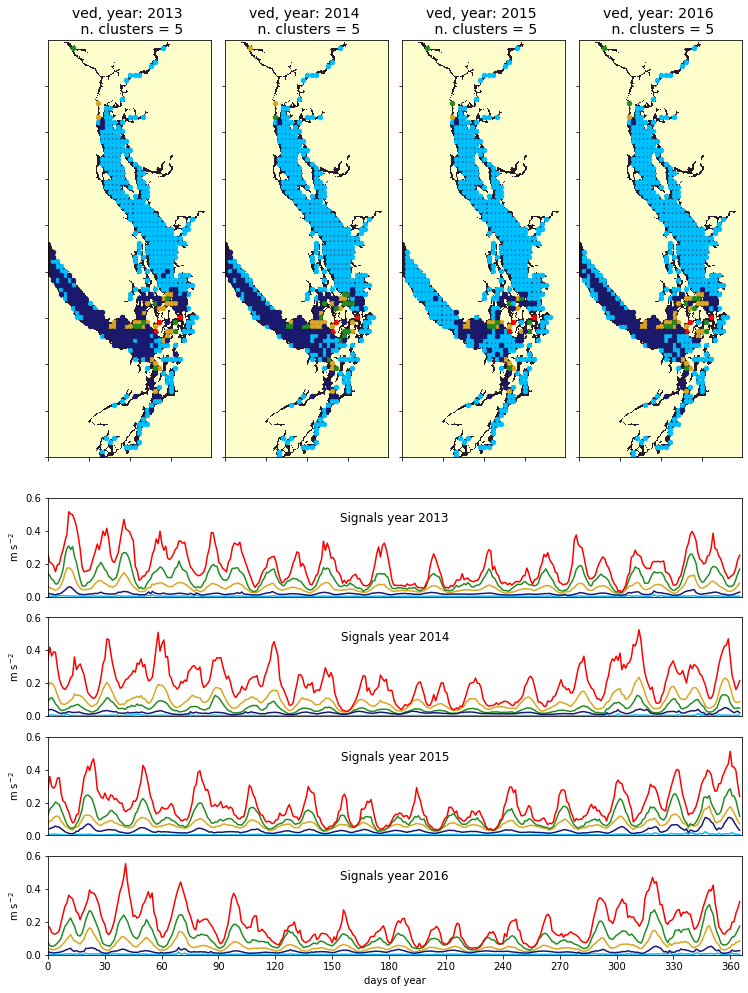

In [30]:
linestyl = ['-',':','-.','--']
sigmats = [sig_2013,sig_2014,sig_2015,sig_2016]
clustmats = [cldes_2013_reass,cldes_2014_reass,cldes_2015_reass,cldes_2016_reass]
clustnos = [5,5,5,5]
nodays =  [365,365,365,366]
labs = ['2013','2014','2015','2016']
t_ylim = 0.6
t_ylab = 'm s$^{-2}$'

fact = 1.5
fig = plt.figure(figsize=(7*fact, 9.25*fact))

ax1 = plt.subplot2grid((8,4), (0,0), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2013','ved',5,cldes_2013_reass, colors, legend = False)
ax1 = plt.subplot2grid((8,4), (0,1), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2014','ved',5,cldes_2014_reass, colors, legend = False)
ax1 = plt.subplot2grid((8,4), (0,2), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2015','ved',5,cldes_2015_reass, colors, legend = False)
ax1 = plt.subplot2grid((8,4), (0,3), colspan=1, rowspan=4) 
vp.clusters_basic(ax1,'2016','ved',5,cldes_2016_reass, colors, legend = False)

ax1 = plt.subplot2grid((8,4), (4,0), colspan=4, rowspan=1)
clustdes = [1,2,3,4,5]; tn = 0; noday = 365
for i in range(0,len(clustdes)):
    tclmat = clustmats[tn]; clustno = clustnos[tn]
    tmean = vp.cluster_patterns_mean(sigmats[tn],tclmat,clustdes[i],noday)
    ax1.plot(np.arange(0,noday,1),np.squeeze(tmean), color = colors[i+1],\
                linestyle = '-')
ax1.set_xlim([0,noday]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks([]);# ax1.set_xlabel('days of year')
ax1.set_title('Signals year 2013', y = 0.7)

ax1 = plt.subplot2grid((8,4), (5,0), colspan=4, rowspan=1)
clustdes = [1,2,3,4,5,6]; tn = 1; noday = 365
for i in range(0,len(clustdes)):
    tclmat = clustmats[tn]; clustno = clustnos[tn]
    tmean = vp.cluster_patterns_mean(sigmats[tn],tclmat,clustdes[i],noday)
    ax1.plot(np.arange(0,noday,1),np.squeeze(tmean), color = colors[i+1],\
                linestyle = '-')
ax1.set_xlim([0,noday]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks([]);# ax1.set_xlabel('days of year')
ax1.set_title('Signals year 2014', y = 0.7)

ax1 = plt.subplot2grid((8,4), (6,0), colspan=4, rowspan=1)
clustdes = [1,2,3,4,5]; tn = 2; noday = 365
for i in range(0,len(clustdes)):
    tclmat = clustmats[tn]; clustno = clustnos[tn]
    tmean = vp.cluster_patterns_mean(sigmats[tn],tclmat,clustdes[i],noday)
    ax1.plot(np.arange(0,noday,1),np.squeeze(tmean), color = colors[i+1],\
                linestyle = '-')
ax1.set_xlim([0,noday]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks([]);# ax1.set_xlabel('days of year')
ax1.set_title('Signals year 2015', y = 0.7)

ax1 = plt.subplot2grid((8,4), (7,0), colspan=4, rowspan=1)
clustdes = [1,2,3,4,5]; tn = 3; noday = 366
for i in range(0,len(clustdes)):
    tclmat = clustmats[tn]; clustno = clustnos[tn]
    tmean = vp.cluster_patterns_mean(sigmats[tn],tclmat,clustdes[i],noday)
    ax1.plot(np.arange(0,noday,1),np.squeeze(tmean), color = colors[i+1],\
                linestyle = '-')
ax1.set_xlim([0,noday]); ax1.set_ylim([0,t_ylim]); ax1.set_ylabel(t_ylab)
ax1.set_xticks(np.arange(0,390,30)); ax1.set_xlabel('days of year')
ax1.set_title('Signals year 2016', y = 0.7)


plt.tight_layout()

var = 'VED'
fig.savefig(f'./paper_figs/{var}_4Y_YEARS_SEP.png', bbox_inches='tight')